In [56]:
import ast
import boto3
import time
import os
from roboflow import Roboflow
import torchvision.transforms as transforms
from PIL import Image
import torch
import pathlib
from pathlib import Path
import shutil
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Load environment variables from .env file
load_dotenv()

# Environment variables (set these before running the script or hard-code them here)
ROBOFLOW_KEY = os.getenv("ROBOFLOW_KEY")  # Your Roboflow API key


def download_dataset_from_roboflow(url):
    parts = url.split("/")
    ds_version = parts[-1]
    ds_project = parts[-3]
    ds_workspace = parts[-4]
    rf = Roboflow(api_key=ROBOFLOW_KEY)
    project = rf.workspace(ds_workspace).project(ds_project)
    version = project.version(ds_version)
    dataset = version.download("yolov11")
    return Path(dataset.location)

In [57]:
base_path = download_dataset_from_roboflow(
    "https://universe.roboflow.com/drone-obstacle-detection/drone-object-detection-yhpn6/dataset/15"
)

loading Roboflow workspace...
loading Roboflow project...


In [58]:
with open(base_path / "data.yaml", "r") as f:
    yaml_file = yaml.safe_load(f)

In [59]:
print(yaml_file)

{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 6, 'names': ['Building', 'Fence', 'House', 'Pole', 'Street Sign', 'Tree'], 'roboflow': {'workspace': 'drone-obstacle-detection', 'project': 'drone-object-detection-yhpn6', 'version': 15, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/drone-obstacle-detection/drone-object-detection-yhpn6/dataset/15'}}


In [60]:
classes = yaml_file["names"]
print("Classes in dataset:", classes)
print("Number of classes in dataset: ", len(classes))
print("Number of training images: ", len(os.listdir(base_path / "train/images")))
print("Number of testing images: ", len(os.listdir(base_path / "test/images")))
print("Number of validation images: ", len(os.listdir(base_path / "valid/images")))

Classes in dataset: ['Building', 'Fence', 'House', 'Pole', 'Street Sign', 'Tree']
Number of classes in dataset:  6
Number of training images:  345
Number of testing images:  12
Number of validation images:  33


In [61]:
def class_counts_per_split(split):
    split_path = base_path / split / "labels"
    class_counts = {}
    for label in os.listdir(split_path):
        with open(split_path / label, "r") as f:
            lines = f.read().splitlines()
        for line in lines:
            class_id = line.split()[0]
            class_id = int(class_id)
            try:
                class_counts[class_id] += 1
            except:
                class_counts[class_id] = 1

    class_count_with_name = {}
    print(f"{split} split")
    print("Class name           | count")
    print("----------------------------")
    for i, c in enumerate(classes):
        try:
            count = class_counts[i]
        except:
            count = 0
        print(f"{c:<20} | {count}")
        class_count_with_name[c] = count
    return class_count_with_name

In [62]:
train_count = class_counts_per_split("train")

train split
Class name           | count
----------------------------
Building             | 471
Fence                | 258
House                | 189
Pole                 | 393
Street Sign          | 129
Tree                 | 1809


In [63]:
test_count = class_counts_per_split("test")

test split
Class name           | count
----------------------------
Building             | 7
Fence                | 6
House                | 6
Pole                 | 17
Street Sign          | 6
Tree                 | 53


In [64]:
valid_count = class_counts_per_split("valid")

valid split
Class name           | count
----------------------------
Building             | 45
Fence                | 16
House                | 18
Pole                 | 42
Street Sign          | 11
Tree                 | 192


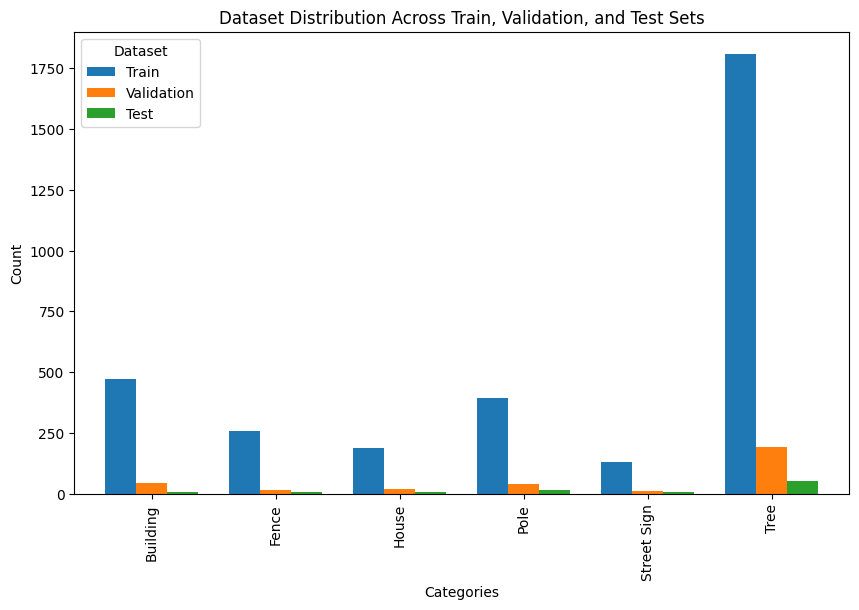

In [65]:
# Create a DataFrame
data = {"Train": train_count, "Validation": valid_count, "Test": test_count}
df = pd.DataFrame(data)

# Plotting
df.plot(kind="bar", figsize=(10, 6), width=0.75)

# Labels and title
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.legend(title="Dataset")

plt.show()